In [1]:
import numpy as np # general math functions
import matplotlib.pyplot as plt

from quspin.operators import hamiltonian# operators
from quspin.basis import spin_basis_1d,tensor_basis # Hilbert spaces
from quspin.tools.measurements import obs_vs_time,diag_ensemble # calculating dynamics

In [2]:
#Parameters for matplotlib
fig_size = [6.9185, 3.4207]
params = {'backend': 'ps',
      'axes.labelsize': 14,
      'font.size': 12,
      'legend.fontsize': 12,
      'axes.titlesize' : 12,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'xtick.direction': 'in',
      'ytick.direction': 'in',
      'xtick.top' : True,
      'ytick.right' : True,
      'legend.frameon' : False,
      'axes.linewidth' : .8,
      'axes.linewidth' : .8,
      'lines.linewidth' : 1.3,
      'figure.figsize': fig_size}
      
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.style.use('seaborn-dark-palette')
plt.rcParams.update(params)

In [3]:
%matplotlib inline

### Quench dynamics in fermionic chains

In [4]:
L = 1000 #System size

J = 1. #Hopping strength
Delta = 2.*J #Pair interaction
mu = 1.*J #Chemical potential

def epsilon_0(k):
    global mu,J
    return -2.*J*np.cos(k)-mu

def epsilon(k):
    global mu,J,Delta
    return np.sqrt(epsilon_0(k)**2 + 4.*Delta**2*np.sin(k)**2)

def theta(k):
    global mu,J,Delta
    return np.arctan(2.*Delta*np.sin(k)/epsilon_0(k))

def f_L(l):
    global L
    k_range = np.arange(L)*2.*np.pi/L
    return (np.sum([np.exp(1j*k_*l)*np.sin(0.5*theta(k_))**2 for k_ in k_range])/L).real

def g_L(l,t):
    global L
    k_range = np.arange(L)*2.*np.pi/L
    return (-0.5*1j*np.sum([np.exp(-1j*k_*l)*np.sin(theta(k_))*np.exp(-2.*1j*epsilon_0(k_)*t) for k_ in k_range])/L).real

In [5]:
t_range = np.arange(0,20,0.02)
l_range = np.arange(-100,101)
corr_range = np.zeros([len(l_range),len(t_range)])

for j,l_j in enumerate(l_range):
    if(j%(len(l_range)//10)==0):
        print(j,"/",len(l_range))
    offset = 0. #np.abs(f_L(l_j))**2
    for i, t_i in enumerate(t_range):
        corr_range[j,i] = np.abs(g_L(l_j,t_i))**2 + offset

0 / 201
20 / 201
40 / 201
60 / 201
80 / 201
100 / 201
120 / 201
140 / 201
160 / 201
180 / 201
200 / 201


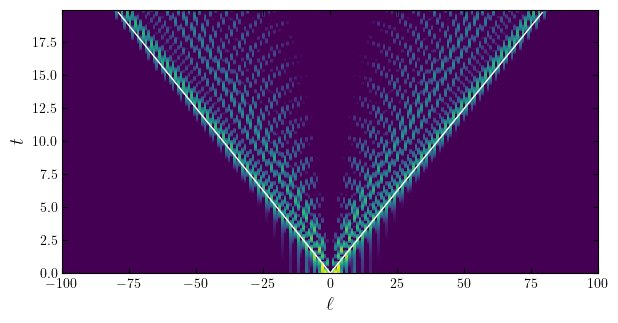

In [6]:
#Show spreading of correlations
fig,ax = plt.subplots()
ax.imshow(np.log(np.abs(corr_range.T+1e-16)), 
          extent=[min(l_range),max(l_range),max(t_range),0],interpolation='None',
          vmin=-8,vmax=np.log(np.abs(np.max(corr_range))))
l_range_lc = np.arange(0.,20.*(4.*J))
ax.plot(l_range_lc,l_range_lc/(4.*J),color='w',linewidth=1.)
ax.plot(-l_range_lc,l_range_lc/(4.*J),color='w',linewidth=1.)

ax.invert_yaxis()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$t$')
ax.set_aspect("auto")
#plt.savefig('Kitaev_lightcone.pdf',bbox_inches='tight')
plt.show()

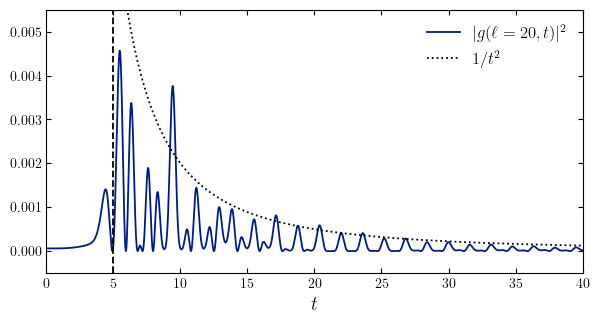

In [7]:
#Show decay of correlations
t_range = np.arange(0,40,0.01)
g_range = np.zeros(len(t_range))

for i, t_i in enumerate(t_range):
    g_range[i] = np.abs(g_L(20,t_i))**2
    
fig,ax = plt.subplots()
ax.plot(t_range,g_range,label=r'$|g(\ell=20,t)|^2$')
ax.plot(t_range[1:],0.2/t_range[1:]**2,'k:',label=r'$1/t^2$')
ax.axvline(20./(4.*J),color='k',linestyle='--')
ax.legend()
ax.set_xlim(0,40)
ax.set_ylim(-0.0005,0.0055)
ax.set_xlabel(r'$t$')
#plt.savefig('decay_g.pdf',bbox_inches='tight')
plt.show()

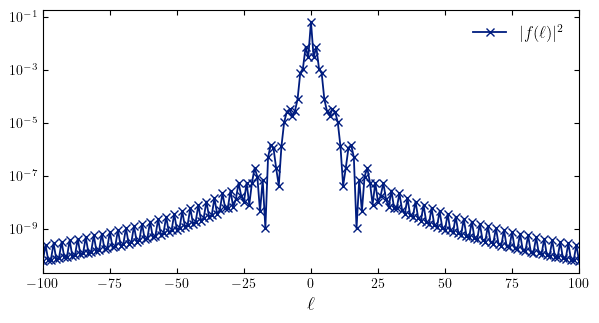

In [8]:
#Show steady-state profile of correlations
l_range = np.arange(-100,101)
f_range = np.zeros(len(l_range))
for i,l_i in enumerate(l_range):
    f_range[i] = f_L(l_i)
    
fig,ax = plt.subplots()
ax.semilogy(l_range,np.abs(f_range)**2,'x-',label=r'$|f(\ell)|^2$')
ax.legend()
ax.set_xlim(min(l_range),max(l_range))
ax.set_xlabel(r'$\ell$')
#plt.savefig('profile_ss_f.pdf',bbox_inches='tight')
plt.show()

### Failure of ETH in the Transverse-Field Ising Model

In the following, we consider the Transverse-Field Ising Hamiltonian,

$$\hat{H} = -J \sum_{j=1}^L \sigma_j^z \sigma_{j+1}^z + h \sum_{j=1}^L \sigma_j^x\,,$$

where we impose periodic boundary conditions and restrict ourselves to the symmetry sector with even parity and zero momentum. Note that this Hamiltonian differs from the Hamiltonian considered in the lecture notes through a change of $\sigma^x \to \sigma^z$ and $\sigma^z \to - \sigma^x$, which can be realized using a spin rotation and does not change any of the results. This change is to be make use of QuSpin's restriction to sectors with fixed spin inversion symmetry along the $z$ direction (fermion parity in the fermionic language).

In [9]:
###Define model parameters
L = 18 # system size
J = 1. # nearest-neighbour interaction
h = 0.9045 # transverse field

#Define basis
basis = spin_basis_1d(L,pauli=True,pblock=1,zblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[-J,i,(i+1) % L] for i in range(L)] # PBC
J_x = [[h,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["x",J_x]]
dynamic = []

#Suppress symmetry checks
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

#Diagonalize the Hamiltonian
E,V=H_Ising.eigh()

As a first numerical check, we calculate the distribution of the normalized level spacing, $s_n = E_{n+1}-E_{n}$, normalized such that $\langle s \rangle = 1$, and compare with the Wigner surmise characterizing Wigner-Dyson statistics,

$$P(s) = \frac{\pi s}{2} \exp(-\pi s^2/4)\,,$$

and the Poisson distribution characteristic of non-chaotic models,

$$P(s) = e^{-s}\,.$$


In [10]:
#Calculate level spacing statistics and compare to GOE

#Focus on center of spectrum of mixed-field Ising model
dim = len(E)
E = E[dim//3:2*dim//3]
print("Number of eigenvalues: ",len(E))

s = np.array([])

#Calculate unfolded level spacing ratio (normalizing mean level spacing ratio at different energies)
s_n = E[1:]-E[:-1]

n_s = 10
dim_s = len(s_n)//n_s

#Normalize level spacing ratio
for i in range(n_s):
    s_sample = s_n[i*dim_s:(i+1)*dim_s]
    s_sample = s_sample / np.average(s_sample)
    s = np.append(s,s_sample)

Number of eigenvalues:  1305


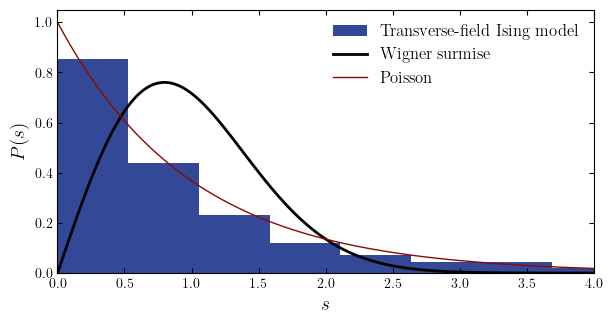

In [11]:
#Plot the level spacing statistics and the Wigner surmise

fig,ax = plt.subplots(figsize=[6.9185, 3.4207])

#Plot histogram from spectrum
n_bins = 20
ax.hist(s, bins = n_bins, 
        density = True,color='C0',alpha=.8,zorder=0,label=r'Transverse-field Ising model')

#Plot Wigner surmise
s_GOE = np.arange(0.,5.,0.01)
ax.plot(s_GOE,0.5*np.pi*s_GOE*np.exp(-0.25*np.pi*s_GOE**2),
        color='k',linewidth=2,zorder=1,label=r'Wigner surmise')
ax.plot(s_GOE,np.exp(-s_GOE),color='C2',linewidth=1,label=r'Poisson')

ax.legend()
ax.set_xlim(0.,4.)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$P(s)$')
plt.show()

For models exhibiting additional conservation laws we do not expect ETH to hold, as can be directly verified numerically.

In [12]:
#Construct basis, Hamiltonian, and observable for different system sizes L=10,14,18
L = 10
basis = spin_basis_1d(L,pauli=True,pblock=1,zblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[-J,i,(i+1) % L] for i in range(L)] # PBC
J_x = [[h,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_10,V_10] = H_Ising.eigh()

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_10 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [13]:
#Construct basis, Hamiltonian, and observable for different system sizes
L = 14
basis = spin_basis_1d(L,pauli=True,pblock=1,zblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[-J,i,(i+1) % L] for i in range(L)] # PBC
J_x = [[h,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_14,V_14] = H_Ising.eigh()

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_14 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [14]:
#Construct basis, Hamiltonian, and observable for different system sizes
L = 18
basis = spin_basis_1d(L,pauli=True,pblock=1,zblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[-J,i,(i+1) % L] for i in range(L)] # PBC
J_x = [[h,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_18,V_18] = H_Ising.eigh()

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_18 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [15]:
#Calculate diagonal matrix elements
exp_diag_10 = np.zeros(len(E_10))
for n in range(len(E_10)):
    exp_diag_10[n] = Obs_10.expt_value(V_10[:,n])

exp_diag_14 = np.zeros(len(E_14))
for n in range(len(E_14)):
    exp_diag_14[n] = Obs_14.expt_value(V_14[:,n])
    
exp_diag_18 = np.zeros(len(E_18))
for n in range(len(E_18)):
    exp_diag_18[n] = Obs_18.expt_value(V_18[:,n])
    

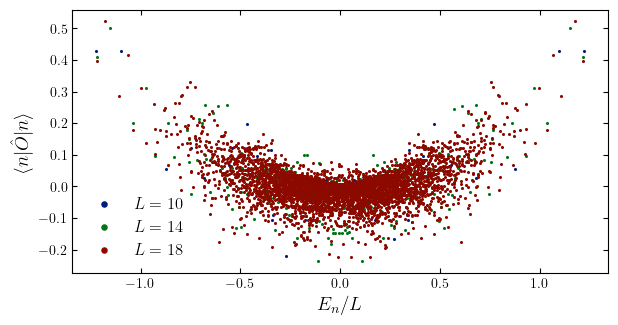

In [16]:
#Plot the diagonal matrix elements as a function of eigenstate energy
fig,ax = plt.subplots()
ax.scatter(E_10/10,exp_diag_10,color='C0',label=r'$L=10$',s=1.5)
ax.scatter(E_14/14,exp_diag_14,color='C1',label=r'$L=14$',s=1.5)
ax.scatter(E_18/18,exp_diag_18,color='C2',label=r'$L=18$',s=1.5)
ax.set_xlabel(r'$E_n/L$')
ax.set_ylabel(r'$\langle n |\hat{O} | n\rangle$')
ax.legend(markerscale=3)
#plt.savefig('TFIM_diagonal.png',bbox_inches='tight',dpi=400)
plt.show()

In [17]:
#Calculate the off-diagonal matrix elements as a function of omega for a fixed energy window
omega_mn = []
obs_mn = []
E_mn = []
for m,E_m in enumerate(E_18):
    for n,E_n in enumerate(E_18):
        if (m!=n and np.abs(E_m+E_n)<.1):
                omega = E_m - E_n
                O_mn = Obs_18.matrix_ele(V_18[:,m],V_18[:,n])
                omega_mn.append(omega)
                obs_mn.append(O_mn)
                E_mn.append(0.5*(E_m+E_n))
            
#Get envelope
omega_args = np.argsort(omega_mn)
d_omega = 0.5
omega_range = np.arange(-30,30+d_omega,d_omega)
avg_abs_range = np.zeros(len(omega_range))
avg_sq_range = np.zeros(len(omega_range))
n_range = np.zeros(len(omega_range))

for i, omega_i in enumerate(omega_mn):
    ind = np.argmin(np.abs(omega_range-omega_i))
    avg_abs_range[ind] += np.abs(obs_mn[i])
    avg_sq_range[ind] += np.abs(obs_mn[i])**2
    n_range[ind] += 1.

#Envelope function
f_obs_2 = avg_sq_range/n_range

#Characterizing Gaussian variables
avg_abs_range = avg_abs_range / n_range
avg_sq_range = avg_sq_range / n_range
fluc_range = avg_sq_range / avg_abs_range**2

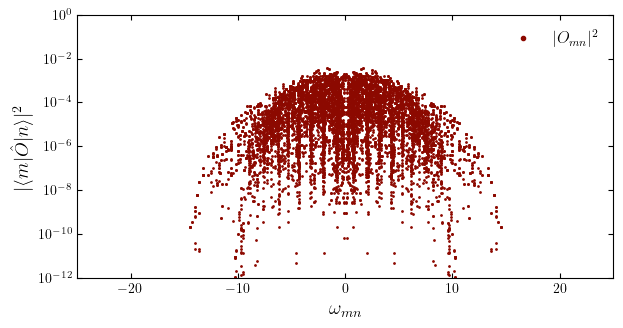

In [18]:
#Plot off-diagonal matrix elements as function of frequency and plot envelope
fig,ax = plt.subplots()
ax.scatter(omega_mn,np.abs(obs_mn)**2,color='C2',s=1.,label=r'$|O_{mn}|^2$')
ax.set_xlabel(r'$\omega_{mn}$')
ax.set_ylabel(r'$|\langle m |\hat{O} | n\rangle|^2$',zorder=0)
#ax.plot(omega_range,f_obs_2,color='k',zorder=1,linewidth=2.,label=r'$|f_O(E=0,\omega)|^2$')
ax.set_yscale("log")
ax.set_ylim(1e-12,1.)
ax.set_xlim(-25,25)
ax.legend(markerscale=3)
#plt.savefig('TFIM_offdiagonal.png',bbox_inches='tight',dpi=400)
plt.show()

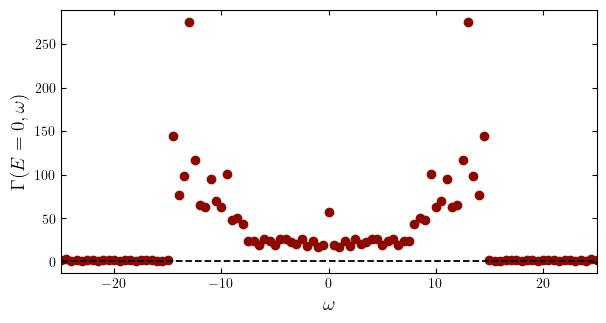

In [19]:
#Plot parameter characterizing fluctuations as function of energy
fig,ax = plt.subplots()
ax.scatter(omega_range,fluc_range,color='C2',zorder=1)
ax.axhline(0.5*np.pi,linestyle='--',color='k')
ax.set_xlim(-25,25)
ax.set_ylabel(r'$\Gamma(E=0,\omega)$')
ax.set_xlabel(r'$\omega$')
#plt.savefig('TFIM_fluctuations.png',bbox_inches='tight',dpi=400)
plt.show()

### Level repulsion

In [20]:
###Define model parameters
L = 14 # system size
J = 1. # nearest-neighbour interactions
h_x = 1. # transverse field

basis = spin_basis_1d(L,pauli=True,pblock=1,zblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[-J,i,(i+1) % L] for i in range(L)] # PBC
J_x = [[h,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz]]

#Variable parameter
def ramp(t):
    return t

ramp_args=[]
dynamic =[["x",J_x,ramp,ramp_args]]

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [21]:
#Calculate full eigenspectrum at various times/parameters
dim = basis.Ns
t_range = np.arange(0,1,0.001)

E_range = np.zeros([len(t_range),dim])

for i, t_i in enumerate(t_range):
    E_range[i] = H_Ising.eigvalsh(time=t_i)

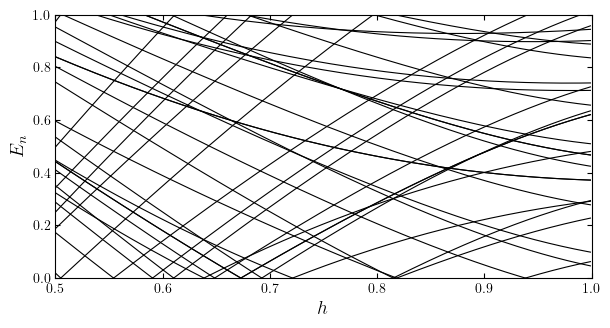

In [22]:
#Plot full eigenspectrum as function of parameter
fig,ax = plt.subplots()
for i in range(dim):
    ax.plot(t_range,E_range[:,i],'k',linewidth=0.8)
ax.set_ylabel(r'$E_n$')
ax.set_xlabel(r'$h$')
ax.set_ylim(0.,1.)
ax.set_xlim(0.5,1.)
#plt.savefig('TFIM_crossing.pdf',bbox_inches='tight')
plt.show()

### Analytic results for transverse-field Ising model

In [23]:
J = 1. #Ising interaction
h_0 = 5. #Transverse field before quench
h = 2. #Transverse field after quench

In [24]:
###Define model parameters
L = 16 # system size
J = J # nearest-neighbour interaction
h_x = h_0 # transverse field
h_z = 0. # longitudinal field

#Define basis
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]


#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Suppress symmetry checks
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

#Diagonalize the Hamiltonian
E,V = H_Ising.eigh()

#Define initial state
psi_init = V[:,np.argmin(E)]

In [25]:
###Define model parameters
L = 16 # system size
J = J # nearest-neighbour interaction
h_x = h # transverse field
h_z = 0. # longitudinal field

#Define basis
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]


#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Suppress symmetry checks
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [26]:
#Define observable
J_x = [[1./L,i] for i in range(L)]

#Static and dynamic lists
static = [["x",J_x]]
dynamic=[]

#Compute the observable
S_z = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

#Time range for dynamics
times = np.linspace(0.0,20.0,401)

#Time evolve initial state under H
psi_t = H_Ising.evolve(psi_init,0.0,times)

#Time evolve observable
Obs_time = obs_vs_time(psi_t,times,dict(S_z = S_z))

In [27]:
#Functions for exact solution
def epsilon_h(k):
    global J,h
    return 2*np.sqrt((J**2+h**2)-2.*J*h*np.cos(k))

def theta(k):
    global J,h
    return np.arctan((-J*np.sin(k))/(h-J*np.cos(k)))

def Delta(k):
    global J,h,h_0
    return np.arctan((-J*np.sin(k))/(h-J*np.cos(k)))-np.arctan((-J*np.sin(k))/(h_0-J*np.cos(k)))

def Ak(k,t):
    res = ( np.cos(theta(k)/2.) * np.cos(Delta(k)/2.) * np.exp(-1j*epsilon_h(k)*t)
           +np.sin(theta(k)/2.) * np.sin(Delta(k)/2.) * np.exp(+1j*epsilon_h(k)*t))
    return res

def Bk(k,t):
    res = (1j*np.cos(theta(k)/2.) * np.sin(Delta(k)/2.) * np.exp(+1j*epsilon_h(k)*t) 
          -1j*np.sin(theta(k)/2.) * np.cos(Delta(k)/2.) * np.exp(-1j*epsilon_h(k)*t))
    return res

def Sz(t,L):
    k_range = (0.5+np.arange(L))*2.*np.pi/L
    return np.sum([np.abs(Bk(k_,t))**2 for k_ in k_range]).real/L

In [28]:
#Calculate decay of correlations
t_range = np.arange(0,20,0.01)
Sz_range = np.zeros(len(t_range))

for i, t_i in enumerate(t_range):
    Sz_range[i] = 2.*Sz(t_i,L=16)-1.

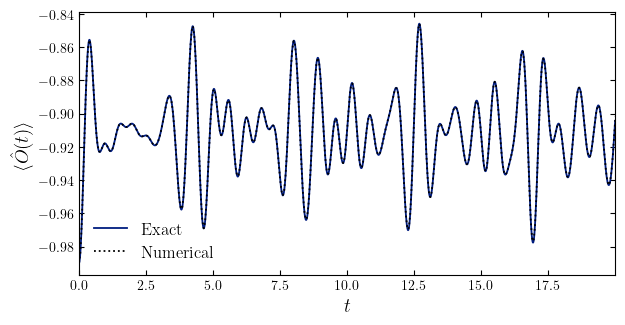

In [29]:
#Show decay of correlations
fig,ax = plt.subplots()
ax.plot(t_range,Sz_range,label='Exact')
ax.plot(times,Obs_time['S_z'].real,'k:',label='Numerical')
ax.set_xlim(0,max(t_range))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \hat{O}(t)\rangle$')
ax.legend()
plt.show()

In [30]:
#Show decay of correlations as system size increases
L_range = [20,40,80]
t_range = np.arange(0,14,0.01)
Sz_range = np.zeros([len(L_range),len(t_range)])

for j,L_j in enumerate(L_range):
    for i, t_i in enumerate(t_range):
        Sz_range[j,i] = 2.*Sz(t_i,L=L_j)-1.

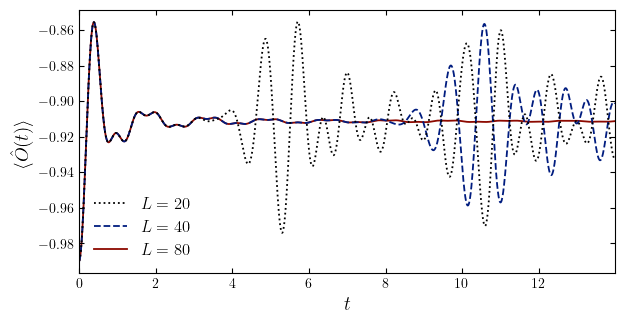

In [31]:
fig,ax = plt.subplots()
ax.plot(t_range,Sz_range[0],'k:',label=r'$L=%s$'%L_range[0],zorder=2)
ax.plot(t_range,Sz_range[1],'C0--',label=r'$L=%s$'%L_range[1],zorder=1)
ax.plot(t_range,Sz_range[2],'C2-',label=r'$L=%s$'%L_range[2],zorder=0)
ax.legend()
ax.set_xlim(0,max(t_range))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \hat{O}(t)\rangle$')
#plt.savefig('TFIM_systemsizes.pdf',bbox_inches='tight')
plt.show()